# Gradient Boosted Regression Trees

Gradient Boosted Regression Trees (GBRT) or Gradient Boosting is a non-parametric statistical learning technique for classification and regression. Other algorithm in tree family will explore Extreme Tree and XGB in other notebook.

In [1]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt
%matplotlib inline

Estimators use support hyperparameters as arguments to control the fitting behaviour. The most important ones for GBRT are:

  * number of regression trees (``n_estimators``)
  * depth of each individual tree (``max_depth``)
  * loss function (``loss``)
  * learning rate (``learning_rate``)

For example if you want to fit a regression model with 100 trees of depth 3 using least-squares:

In [2]:
gbr = GradientBoostingRegressor(n_estimators=100, max_depth=3, loss='ls')

During the fitting process, the state of the estimator is stored in instance attributes that have a trailing underscore ('\_'). For example, the sequence of regression trees (``sklearn.tree.DecisionTreeRegressor`` objects) is stored in ``est.estimators_``.

The following code illustratedhow to fit a ``GradientBoostingClassifier`` to a synthetic dataset (taken from [Hastie et al., _The Elements of Statistical Learning_, Ed2]):

In [3]:
from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import train_test_split, GridSearchCV,ShuffleSplit

# generate synthetic data from ESLII - Example 10.2
X, y = make_hastie_10_2(n_samples=5000)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# fit estimator
gbc = GradientBoostingClassifier(n_estimators=200, max_depth=3)
gbc.fit(X_train, y_train)

# predict class labels
pred = gbc.predict(X_test)

# score on test data (accuracy)
acc = gbc.score(X_test, y_test)
print('ACC: %.4f' % acc)

# predict class probabilities
gbc.predict_proba(X_test)[0]

ACC: 0.9120


array([ 0.05134332,  0.94865668])

## Gradient Boosting usage

Most of the challenges in applying GBRT successfully in practise can be illustrated in the context of a simple curve fitting example. Below you can see a regression problem with one feature ``x`` and the corresponding response ``y``. We draw 100 training data points by picking an ``x`` coordinate uniformly at random, evaluating the ground truth (sinoid function; light blue line) and then adding some random gaussian noise. In addition to the 100 training points (blue) we also draw 100 test data points (red) which we will use the evaluate our approximation.

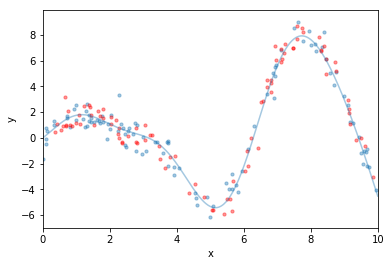

In [4]:
import numpy as np

def ground_truth(x):
    """Ground truth -- function to approximate"""
    return x * np.sin(x) + np.sin(2 * x)

def gen_data(n_samples=200):
    """generate training and testing data"""
    np.random.seed(13)
    x = np.random.uniform(0, 10, size=n_samples)
    x.sort()
    y = ground_truth(x) + 0.75 * np.random.normal(size=n_samples)
    train_mask = np.random.randint(0, 2, size=n_samples).astype(np.bool)
    x_train, y_train = x[train_mask, np.newaxis], y[train_mask]
    x_test, y_test = x[~train_mask, np.newaxis], y[~train_mask]
    return x_train, x_test, y_train, y_test
    

X_train, X_test, y_train, y_test = gen_data(200)

# plot ground truth
x_plot = np.linspace(0, 10, 500)

def plot_data():
    
    gt = plt.plot(x_plot, ground_truth(x_plot), alpha=0.4, label='ground truth')

    # plot training and testing data
    plt.scatter(X_train, y_train, s=10, alpha=0.4)
    plt.scatter(X_test, y_test, s=10, alpha=0.4, color='red')
    plt.xlim((0, 10))
    plt.ylabel('y')
    plt.xlabel('x')
    
plot_data()

If you fit an individual regression tree to the above data you get a piece-wise constant approximation. The deeper you grow the tree the more constant segments you can accomodate thus the more variance you can capture.

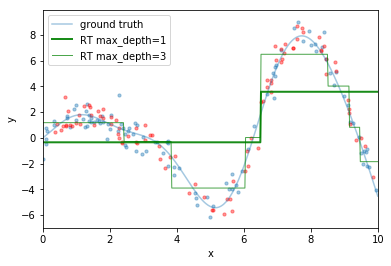

In [5]:
from sklearn.tree import DecisionTreeRegressor
plot_data()
dtr = DecisionTreeRegressor(max_depth=1).fit(X_train, y_train)
plt.plot(x_plot, dtr.predict(x_plot[:, np.newaxis]),
         label='RT max_depth=1', color='g', alpha=0.9, linewidth=2)

dtr = DecisionTreeRegressor(max_depth=3).fit(X_train, y_train)
plt.plot(x_plot, dtr.predict(x_plot[:, np.newaxis]),
         label='RT max_depth=3', color='g', alpha=0.7, linewidth=1)

plt.legend(loc='upper left')

Now lets fit a gradient boosting model to the training data and lets see how the approximation progresses as we add more and more trees. 

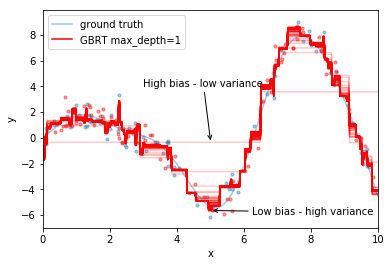

In [6]:
from itertools import islice

plot_data()

dtr = GradientBoostingRegressor(n_estimators=1000, max_depth=1, learning_rate=1.0)
dtr.fit(X_train, y_train)

ax = plt.gca()
first = True

# step over prediction as we added 20 more trees.
for pred in islice(dtr.staged_predict(x_plot[:, np.newaxis]), 0, 1000, 10):
    plt.plot(x_plot, pred, color='r', alpha=0.2)
    if first:
        ax.annotate('High bias - low variance', xy=(x_plot[x_plot.shape[0] // 2],
                                                    pred[x_plot.shape[0] // 2]),
                                                    xycoords='data',
                                                    xytext=(3, 4), textcoords='data',
                                                    arrowprops=dict(arrowstyle="->",
                                                                    connectionstyle="arc"))
        first = False

pred = dtr.predict(x_plot[:, np.newaxis])
plt.plot(x_plot, pred, color='r', label='GBRT max_depth=1')
ax.annotate('Low bias - high variance', xy=(x_plot[x_plot.shape[0] // 2],
                                            pred[x_plot.shape[0] // 2]),
                                            xycoords='data', xytext=(6.25, -6),
                                            textcoords='data', arrowprops=dict(arrowstyle="->",
                                                                               connectionstyle="arc"))
plt.legend(loc='upper left')

The above plot shows 50 red lines, each shows the response of the GBRT model after 20 trees have been added. It starts with a very crude approximation that can only fit more-or-less constant functions (ie. _High bias - low variance_) but as we add more trees the more variance our model can capture resulting in the solid red line.

We can see that the more trees we add to our GBRT model and the deeper the individual trees are the more variance we can capture thus the higher the complexity of our model. But as usual in machine learning model complexity comes at a price -- *overfitting*.

An important diagnostic when using GBRT in practise is the so-called *deviance plot* that shows the training/testing error (or deviance) as a function of the number of trees.

Text(810,0.25,'train-test gap')

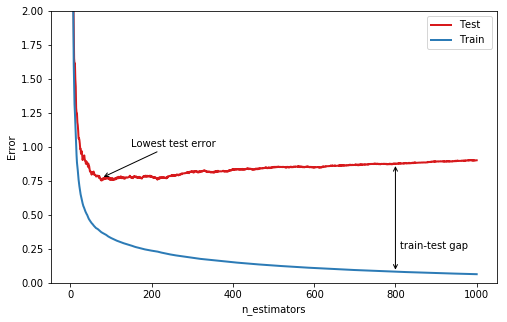

In [7]:
n_estimators = len(dtr.estimators_)

def deviance_plot(dtr, X_test, y_test, ax=None, label='', train_color='#2c7bb6', 
                  test_color='#d7191c', alpha=1.0):
    """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
    test_dev = np.empty(n_estimators)

    for i, pred in enumerate(dtr.staged_predict(X_test)):
        test_dev[i] = dtr.loss_(y_test, pred)

    if ax is None:
        fig = plt.figure(figsize=(8, 5))
        ax = plt.gca()
        
    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label, 
             linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, dtr.train_score_, color=train_color, 
             label='Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    ax.set_ylim((0, 2))
    return test_dev, ax

test_dev, ax = deviance_plot(dtr, X_test, y_test)
ax.legend(loc='upper right')

# add some annotations
ax.annotate('Lowest test error', xy=(test_dev.argmin() + 1, test_dev.min() + 0.02), xycoords='data',
            xytext=(150, 1.0), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )

ann = ax.annotate('', xy=(800, test_dev[799]),  xycoords='data',
                  xytext=(800, dtr.train_score_[799]), textcoords='data',
                  arrowprops=dict(arrowstyle="<->"))
ax.text(810, 0.25, 'train-test gap')

The blue line above shows the training error: it rapidly decreases in the beginning and then gradually slows down but keeps decreasing as we add more and more trees. The testing error (red line) too decreases rapidly in the beginning but then slows down and reaches its minimum fairly early (~50 trees) and then even starts increasing.
This is what we call *overfitting*, at a certain point the model has so much capacity that it starts fitting the idiosyncrasies of the training data -- in our case the random gaussian noise component that we added -- and hence limiting its ability to generalize to new unseen data. A large gap between training and testing error is usually a sign of overfitting.

The great thing about gradient boosting is that it provides a number of knobs to control overfitting. These are usually subsummed by the term *regularization*.

### Regularization

Gradient Boost Regression Tree provide three knobs to control overfitting: tree structure, shrinkage, and randomization.

#### Tree Structure

The depth of the individual trees is one aspect of model complexity. The depth of the trees basically control the degree of feature interactions that your model can fit. For example, if you want to capture the interaction between a feature ``latitude`` and a feature ``longitude`` your trees need a depth of at least two to capture this. Unfortunately, the degree of feature interactions is not known in advance but it is usually fine to assume that it is faily low -- in practise, a depth of 4-6 usually gives the best results. In scikit-learn you can constrain the depth of the trees using the ``max_depth`` argument.

Another way to control the depth of the trees is by enforcing a lower bound on the number of samples in a leaf: this will avoid inbalanced splits where a leaf is formed for just one extreme data point. In scikit-learn you can do this using the argument ``min_samples_leaf``. This is effectively a means to introduce bias into your model with the hope to also reduce variance as shown in the example below:

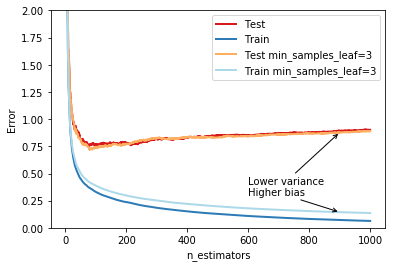

In [8]:
def fmt_params(params):
    return ", ".join("{0}={1}".format(key, val) for key, val in params.items())
fig = plt.figure()
ax = plt.gca()
for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
                                          ({'min_samples_leaf': 3},
                                           ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=1, learning_rate=1.0)
    est.set_params(**params)
    est.fit(X_train, y_train)
    
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)
    
ax.annotate('Higher bias', xy=(900, est.train_score_[899]), xycoords='data',
            xytext=(600, 0.3), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )
ax.annotate('Lower variance', xy=(900, test_dev[899]), xycoords='data',
            xytext=(600, 0.4), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )
plt.legend(loc='upper right')

#### Shrinkage

The most important regularization technique for GBRT is shrinkage: the idea is basically to do slow learning by shrinking the predictions of each individual tree by some small scalar, the ``learning_rate``. By doing so the model has to re-enforce concepts. A lower ``learning_rate`` requires a higher number of ``n_estimators`` to get to the same level of training error -- so its trading runtime against accuracy.

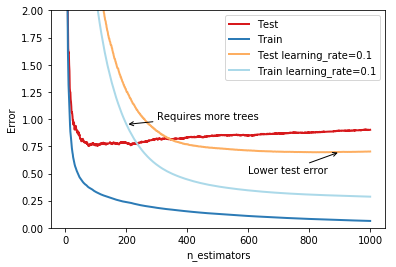

In [9]:
fig = plt.figure()
ax = plt.gca()
for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
                                          ({'learning_rate': 0.1},
                                           ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=1, learning_rate=1.0)
    est.set_params(**params)
    est.fit(X_train, y_train)
    
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)
    
ax.annotate('Requires more trees', xy=(200, est.train_score_[199]), xycoords='data',
            xytext=(300, 1.0), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )
ax.annotate('Lower test error', xy=(900, test_dev[899]), xycoords='data',
            xytext=(600, 0.5), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )
plt.legend(loc='upper right')

#### Stochastic Gradient Boosting

Similar to ``RandomForest``, introducing randomization into the tree building process can lead to higher accuracy. Scikit-learn provides two ways to introduce randomization: a) subsampling the training set before growing each tree (``subsample``) and b) subsampling the features before finding the best split node (``max_features``).
Experience showed that the latter works better if there is a sufficient large number of features (>30).
One thing worth noting is that both options reduce runtime.

Below we show the effect of using ``subsample=0.5``, ie. growing each tree on 50% of the training data,  on our toy example:

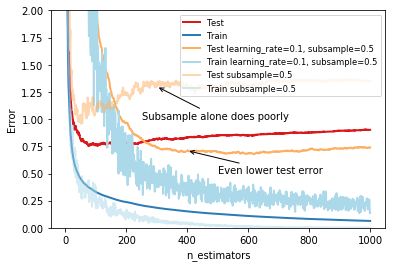

In [10]:
fig = plt.figure()
ax = plt.gca()
for params, (test_color, train_color) in [({}, ('#d7191c', '#2c7bb6')),
                                          ({'learning_rate': 0.1, 'subsample': 0.5},
                                           ('#fdae61', '#abd9e9'))]:
    est = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=1, learning_rate=1.0,
                                    random_state=1)
    est.set_params(**params)
    est.fit(X_train, y_train)
    test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params(params),
                                 train_color=train_color, test_color=test_color)
    
ax.annotate('Even lower test error', xy=(400, test_dev[399]), xycoords='data',
            xytext=(500, 0.5), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )

est = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=1, learning_rate=1.0,
                                subsample=0.5)
est.fit(X_train, y_train)
test_dev, ax = deviance_plot(est, X_test, y_test, ax=ax, label=fmt_params({'subsample': 0.5}),
                             train_color='#abd9e9', test_color='#fdae61', alpha=0.5)
ax.annotate('Subsample alone does poorly', xy=(300, test_dev[299]), xycoords='data',
            xytext=(250, 1.0), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc"),
            )
plt.legend(loc='upper right', fontsize='small')

### Hyperparameter tuning

We now have introduced a number of hyperparameters -- as usual in machine learning it is quite tedious to optimize them. Especially, since they interact with each other (``learning_rate`` and ``n_estimators``, ``learning_rate`` and ``subsample``, ``max_depth`` and ``max_features``).

We usually follow this recipe to tune the hyperparameters for a gradient boosting model:

  1. Choose ``loss`` based on your problem at hand (ie. target metric)
  2. Pick ``n_estimators`` as large as (computationally) possible (e.g. 3000).
  3. Tune ``max_depth``, ``learning_rate``, ``min_samples_leaf``, and ``max_features`` via grid search.
  4. Increase ``n_estimators`` even more and tune ``learning_rate`` again holding the other parameters fixed.
    


In [11]:
param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5, 9, 17],
              # 'max_features': [2,1] 
              }

gbr = GradientBoostingRegressor(n_estimators=1000)
gs_cv = GridSearchCV(gbr, param_grid, n_jobs=4).fit(X_train, y_train)

# best hyperparameter setting
gs_cv.best_params_

{'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 5}

## Case study: California Housing

This use-case study shows how to apply GradientBoostRegressorTree to a real-world dataset. The task is to predict the log median house value for census block groups in California. The dataset is based on the 1990 censues comprising roughly 20.000 groups. There are 8 features for each group including: median income, average house age, latitude, and longitude.
California housing dataset. The original database is available from StatLib http://lib.stat.cmu.edu/ The data contains 20,640 observations on 9 variables. This dataset contains the average house value as target variable and the following input variables (features): average income, housing average age, average rooms, average bedrooms, population, average occupation, latitude, and longitude in that order. - [Credit]("https://shankarmsy.github.io/stories/gbrt-sklearn.html#sthash.KYdlMhEO.dpuf")
To be consistent with [Hastie et al., *The Elements of Statistical Learning*, Ed2] we use Mean Absolute Error as our target metric and evaluate the results on an 80-20 train-test split.

In [12]:
import pandas as pd

from sklearn.datasets import fetch_california_housing
cal_housing = fetch_california_housing() 

# split 80/20 train-test
X_train, X_test, y_train, y_test = train_test_split(cal_housing.data,
                                                    np.log(cal_housing.target),
                                                    test_size=0.2,
                                                    random_state=1)
names = cal_housing.feature_names

Some of the aspects that make this dataset challenging are: a) heterogenous features (different scales and distributions) and b) non-linear feature interactions (specifically latitude and longitude).
Furthermore, the data contains some extreme values of the response (log median house value) -- such a dataset strongly benefits from robust regression techniques such as huberized loss functions.

Below you can see histograms for some of the features and the response. You can see that they are quite different: median income is left skewed, latitude and longitude are bi-modal, and log median house value is right skewed.

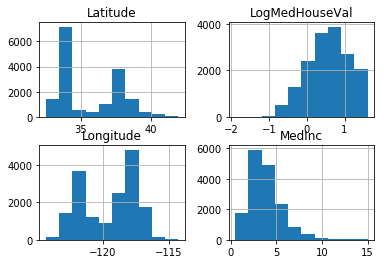

In [13]:
X_df = pd.DataFrame(data=X_train, columns=names)
X_df['LogMedHouseVal'] = y_train
_ = X_df.hist(column=['Latitude', 'Longitude', 'MedInc', 'LogMedHouseVal'])

Lets fit a GBRT model to this dataset and inspect the model

In [14]:
gbr = GradientBoostingRegressor(n_estimators=1000, max_depth=6, learning_rate=0.04,
                                loss='huber', random_state=0)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.04, loss='huber', max_depth=6,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=0, subsample=1.0, verbose=0,
             warm_start=False)

In [15]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, gbr.predict(X_test))
print('MAE: %.4f' % mae)

MAE: 0.1479


### Feature importance

Often features do not contribute equally to predict the target response. When interpreting a model, the first question usually is: what are those important features and how do they contributing in predicting the target response?

A GBRT model derives this information from the fitted regression trees which intrinsically perform feature selection by choosing appropriate split points. You can access this information via the instance attribute ``est.feature_importances_``.

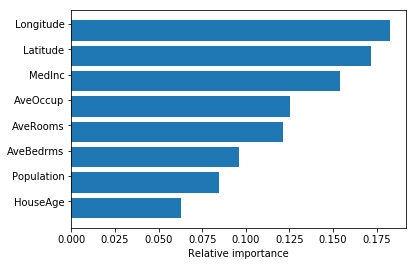

In [16]:
# sort importances
indices = np.argsort(gbr.feature_importances_)
# plot as bar chart
plt.barh(np.arange(len(names)), gbr.feature_importances_[indices])
plt.yticks(np.arange(len(names)) + 0.25, np.array(names)[indices])
_ = plt.xlabel('Relative importance')

### Partial dependence

Partial dependence plots show the dependence between the response and a set of features, marginalizing over the values of all other features. Intuitively, we can interpret the partial dependence as the expected response as a function of the features we conditioned on.

The plot below contains 4 one-way partial depencence plots (PDP) each showing the effect of an idividual feature on the repsonse. We can see that median income ``MedInc`` has a linear relationship with the log median house value.
The contour plot shows a two-way PDP. Here we can see an interesting feature interaction. It seems that house age itself has hardly an effect on the response but when ``AveOccup`` is small it has an effect (the older the house the higher the price).

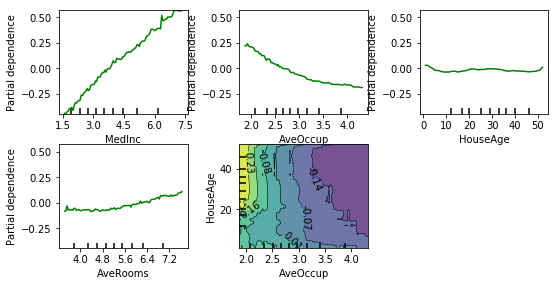

In [17]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

features = ['MedInc', 'AveOccup', 'HouseAge', 'AveRooms',
            ('AveOccup', 'HouseAge')]
fig, axs = plot_partial_dependence(gbr, X_train, features,
                                   feature_names=names, figsize=(8, 6))

Scikit-learn provides a convenience function to create such plots: ``sklearn.ensemble.partial_dependence.plot_partial_dependence`` or a low-level function that you can use to create custom partial dependence plots (e.g. map overlays or 3d plots). 
More detailed information can be found [here](http://scikit-learn.org/dev/modules/ensemble.html#partial-dependence).

In [21]:
#All right let's do this the right way. We'll use a cross-validation generator to select train and CV datasets to finetune 
#parameters such as C (Regularization parameter we saw earlier). 
# These hyperparameters are extremely critical to the model. 
# Now, if we tune parameters against the Test dataset, we will end up biasing towards the test
# set and will once again not generalize very well. We will also have no good way to find out
# since we have essentially trained on all our data.
#Sklearn provides a crossvalidation generator that can train the model by tuning the parameters
#based on a cross-validation subset (cv) that is picked from within the training set.
#A different cv subset will be picked for each iteration, we control the number of iterations.
#Then we will use these cv/train splits and run a gridsearch function that will evaluate the 
#model with each split and tune parameters to give us the best parameter that gives the 
# optimal result.
#Defining this as a function so we can call it anytime we want 
def GradientBooster(param_grid, n_jobs): 
    estimator = GradientBoostingRegressor() #Choose cross-validation generator - 
    #let's choose ShuffleSplit which randomly shuffles and selects Train and CV sets
    #for each iteration. There are other methods like the KFold split.
    cv = ShuffleSplit(X_train.shape[0],  test_size=0.2) 
    #Apply the cross-validation iterator on the Training set using GridSearchCV. This will 
    # run the classifier on the different train/cv splits using parameters specified and 
    # return the model that has the best results #Note that we are tuning based on the F1 score 
    #2PR/P+R where P is Precision and R is Recall. This may not always be the best score to 
    #tune our model on. We'll use F1. 
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
    #Also note that we're feeding multiple neighbors to the GridSearch to try out.
    #We'll now fit the training dataset to this classifier 
    classifier.fit(X_train, y_train) #Let's look at the best estimator that was found by 
    # GridSearchCV 
    print("Best Estimator learned through GridSearch") 
    print(classifier.best_estimator_ )
    return cv, classifier.best_estimator_

All right let's do this the right way. We'll use a cross-validation generator to select train and CV datasets to finetune #parameters such as C (Regularization parameter we saw earlier). These hyperparameters are extremely critical to the model. 

Now, if we tune parameters against the Test dataset, we will end up biasing towards the test set and will once again #not generalize very well. We will also have no good way to find out since we have essentially trained on all our data. #Luckily scikit-learn has builit-in packages that can help with this. We'll use a crossvalidation generator that #can train the model by tuning the parameters based on a cross-validation subset (cv) that is picked from within the #training set. A different cv subset will be picked for each iteration, we control the number of iterations. Then we will #use these cv/train splits and run a gridsearch function that will evaluate the model with each split and tune parameters #to give us the best parameter that gives the optimal result.

Defining this as a function so we can call it anytime we want 

In [22]:
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve 

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)): 
    """ Generate a simple plot of the test and traning learning curve. 
    Parameters
    ---------- 
    estimator : object type that implements the "fit" and "predict" methods.
    An object of that type which is cloned for each validation.
    title : string 
        Title for the chart.
    X : array-like, shape (n_samples, n_features) 
        Training vector, where n_samples is the number of samples and 
        n_features is the number of features. 
    y : array-like, shape (n_samples) or (n_samples, n_features), optional 
        Target relative to X for classification or regression; 
        None for unsupervised learning. 
        ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.
    cv : integer, cross-validation generator, optional If an integer is passed, 
        it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed,  for the list of possible objects
    n_jobs :
        integer, optional Number of jobs to run in parallel (default 1). """ 
    plt.figure() 
    plt.title(title) 
    if ylim is not None: 
        plt.ylim(*ylim) 
        plt.xlabel("Training examples")
        plt.ylabel("Score") 
        train_sizes, train_scores, test_scores = learning_curve( estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1) 
        train_scores_std = np.std(train_scores, axis=1) 
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1) 
        plt.grid() 
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g") 
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score") 
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        plt.legend(loc="best") 
        return plt 
    

In [23]:
param_grid={'n_estimators':[50],
            'learning_rate': [0.1],
            'max_depth':[4], 
            'min_samples_leaf':[2], 
            'max_features':[1.0],
           }
n_jobs=4
cv,best_est=GradientBooster(param_grid, n_jobs)  

Best Estimator learned through GridSearch
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=1.0,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=2,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=50, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


In [24]:
print("Best Estimator Parameters")
print("---------------------------")
print("n_estimators: %d" %best_est.n_estimators)
print("max_depth: %d" %best_est.max_depth)
print("Learning Rate: %.1f" %best_est.learning_rate)
print("min_samples_leaf: %d" %best_est.min_samples_leaf)
print("max_features: %.1f" %best_est.max_features)
print
print("Train R-squared: %.2f" %best_est.score(X_train,y_train))

Best Estimator Parameters
---------------------------
n_estimators: 50
max_depth: 4
Learning Rate: 0.1
min_samples_leaf: 2
max_features: 1.0
Train R-squared: 0.81


In [ ]:
title = "Learning Curves (Gradient Boosted Regression Trees)"
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth, learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf, max_features=best_est.max_features) 
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)
plt.show() 

In [ ]:
title = "Learning Curves (Gradient Boosted Regression Trees)"
estimator = GradientBoostingRegressor(n_estimators=1000, max_depth=best_est.max_depth, learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf, max_features=best_est.max_features) 
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)
plt.show() 

In [ ]:
estimator = best_est 
#Re-fitting to the train set 
estimator.fit(X_train, y_train) 
#Calculating train/test scores - R-squared value 
print("Train R-squared: %.2f" %estimator.score(X_train, y_train))
print("Test R-squared: %.2f" %estimator.score(X_test, y_test)) -